This notebook presents all the analysis reported in Study 8 of the paper.

Click the "Show Code" buttons to see the code associated with each output.

# Preamble

## Libraries

In [1]:
# Misc
import warnings

warnings.filterwarnings("ignore")


# Data libraries
import pandas as pd
import numpy as np

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

sns.set_context("notebook")

# Statistics
import statsmodels.formula.api as smf
import scipy.stats as stats

# Interface with R
import rpy2

%load_ext rpy2.ipython


%R library(sjstats); # For effect sizes of ANOVAs

STUDY_NAME = "Study 8"

## Functions

In [2]:
def plot_design(save=False, show=True, grayscale=False, figname=f"{STUDY_NAME} - Design"):
    # fmt: off
    low = [6, 7, 9, 9, 10, 11, 12, 12, 13, 13, 14, 14, 15, 16, 
              16, 17, 17, 18, 18, 19, 20, 21, 21, 23, 24]
    med = [16, 17, 19, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25, 
              26, 26, 27, 27, 28, 28, 29, 30, 31, 31, 33, 34]
    high = [26, 27, 29, 29, 30, 31, 32, 32, 33, 33, 34, 34, 35, 
               36, 36, 37, 37, 38, 38, 39, 40, 41, 41, 43, 44]
    # fmt: on

    if grayscale:
        pal = sns.color_palette("Greys")[2::3]
        pathname = "Grayscale"
    else:
        pal = sns.color_palette()[0:2]
        pathname = "Color"

    if show:
        sns.set_context("notebook")
    else:
        sns.set_context("paper")

    sns.set_style("ticks")
    fig, axes = plt.subplots(3, 1, figsize=(6.38, 6.38))
    axes = axes.flatten()
    for i, (manip, common, title) in enumerate(
        zip(
            [low, med, high],
            [med, med, med],
            ["Low (M = 15)", "Med (M = 25)", "High (M = 35)"],
        )
    ):
        ax = axes[i]
        ax.annotate(title, (15 + 10 * i, 3), size=12, va="center", ha="center")
        bins = np.arange(0, 51, 1)
        ax.hist(
            common,
            bins=bins,
            label="Common",
            color=pal[1],
            density=False,
            align="left",
            rwidth=0.7,
            lw=0,
        )
        ax.hist(
            manip,
            bins=bins,
            label="Manipulated",
            color=pal[0],
            density=False,
            align="left",
            rwidth=0.35,
            lw=0,
        )
        leg = ax.legend()
        han = leg.legendHandles
        leg.remove()
        ax.set_xticks(np.arange(6, 46, 2))
        ax.set_xticklabels([f"${i}" for i in np.arange(6, 46, 2)])
        ax.set_xlim(5, 45)
        ax.set_ylim(0, 4)
        ax.set_yticks(np.arange(0, 4, 1))
        ax.set_ylabel("Number of Items")

    axes[0].legend(
        handles=han,
        loc="center left",
        title="Category",
        frameon=False,
        bbox_to_anchor=(0.7, 0.75),
    )
    sns.despine()
    plt.tight_layout()

    if save:
        plt.savefig(
            f"../Figures/{pathname}/{figname}.png", dpi=100, bbox_inches="tight"
        )
    if show:
        plt.show()
    else:
        plt.close()


def plot_result_stats(
    data,
    save=False,
    show=True,
    grayscale=False,
    figname=f"Fig 14 - {STUDY_NAME} - Mean By Group",
):

    if grayscale:
        pal = sns.color_palette("Greys")[1::2]
        pathname = "Grayscale"
    else:
        pal = sns.color_palette("coolwarm", 3)
        pathname = "Color"

    if show:
        sns.set_context("notebook")
    else:
        sns.set_context("paper")

    sns.set_style("white")
    g = sns.catplot(
        x="is_manipulated",
        hue="mean_manipulated",
        hue_order=["Low", "Med", "High"],
        y="value",
        data=data,
        kind="bar",
        row="variable",
        aspect=1.7,
        height=6.38 / 1.7,
        order=[True, False],
        sharey=False,
        sharex=False,
        legend_out=False,
        palette=pal,
    )

    g.set_titles("")
    g.set_xlabels("")
    axes = g.axes.flatten()
    leg = axes[0].legend()

    han = leg.legendHandles
    leg.remove()

    axes[0].legend(
        han,
        ["Low (M = 15)", "Med (M = 25)", "High (M = 35)"],
        title="Mean of Manipulated Category",
        loc="upper center",
        bbox_to_anchor=(0.75, 1.03),
        frameon=False,
    )
    axes[0].set_ylim(12, 40)
    axes[0].set_xticklabels(["Manipulated Category", "Common Category (M = 25)"])
    axes[0].set_ylabel("Mean of Reported Prices")

    axes[1].set_ylim(10, 24)
    axes[1].set_xticklabels(["Manipulated Category", "Common Category (M = 25)"])
    axes[1].set_ylabel("Range of Reported Prices")
    fig = plt.gcf()
    fig.set_size_inches(6.38, 7)
    if save:
        plt.savefig(
            f"../Figures/{pathname}/{figname}.png", dpi=100, bbox_inches="tight"
        )
    if show:
        plt.show()
    else:
        plt.close()

## Data loading and preparation

In [3]:
# Data loading and preparation
df = (
    pd.read_csv(f"../Data/{STUDY_NAME}/LongData.csv")
    .groupby(
        ["turkid", "wine", "is_manipulated", "mean_manipulated"]
    )
    .value.agg(
        **{
            "value_sd": np.std,
            "value_range": lambda x: np.max(x) - np.min(x),
            "value_min": np.min,
            "value_max": np.max,
            "value_mean": np.mean,
            "value_mode": lambda x: stats.mode(x)[0],
            "value_var": lambda x: np.std(x) ** 2,
        }
    )
    .reset_index()
)

# Design

## Characteristics and distributions

All participants saw two distributions:

* Common: Constant Mean, M = 25
* Manipulated: Manipulated Mean between subjects, $M \in [15, 25, 35]$

Visualization of the distributions:

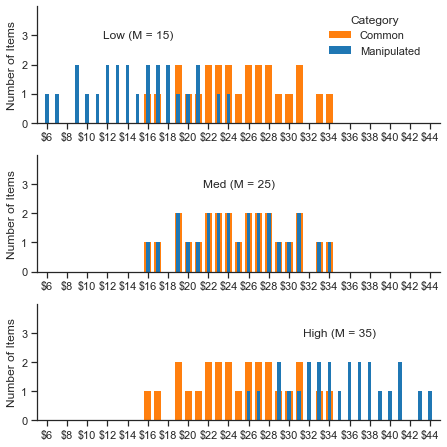

In [4]:
plot_design(save=False, show=True)

## Number of valid participants

In [5]:
df.turkid.unique().shape[0]

149

# Analysis

## Overview of results

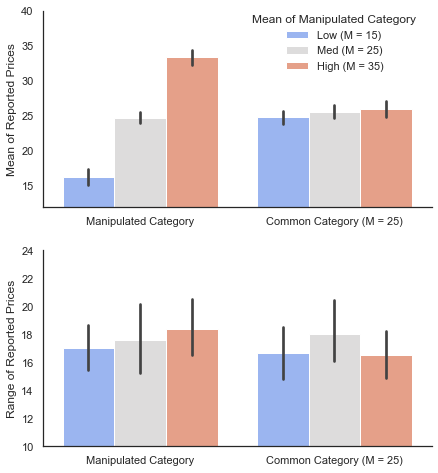

In [6]:
df_both = pd.melt(
    df,
    id_vars=["is_manipulated", "mean_manipulated"],
    value_vars=["value_mean", "value_range"],
)
plot_result_stats(df_both, grayscale=True, save=True, show=False)
plot_result_stats(df_both, save=True, show=True)
table = (
    df.groupby(["is_manipulated", "mean_manipulated"])[["value_mean", "value_range"]]
    .mean()
    .reindex(
        labels=[
            [False, False, False, True, True, True],
            ["Low", "Med", "High", "Low", "Med", "High"],
        ]
    )
)
table.index.names = ["Manipulated?", "Mean of Manipulated"]
table.columns = ["Mean", "Range"]
table.style.format("{:.2f}")

## Mean

### Pairwise Contrasts for Manipulated Category

In [7]:
results = smf.mixedlm(
    "value_mean ~ C(mean_manipulated, levels=['Med', 'Low', 'High'])\
*C(is_manipulated, Treatment(1))",
    groups=df.turkid,
    data=df,
).fit()
results.summary(
    xname_fe=[
        "Manipulated: Medium",
        "Manipulated: Low vs. Medium",
        "Manipulated: High vs. Medium",
        "Medium: Common vs. Manipulated",
        "Low: Common vs. Manipulated",
        "High: Common vs. Manipulated",
    ],
    yname="Mean",
)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:                    MixedLM       Dependent Variable:       Mean     
No. Observations:         298           Method:                   REML     
No. Groups:               149           Scale:                    10.9182  
Min. group size:          2             Log-Likelihood:           -801.0643
Max. group size:          2             Converged:                Yes      
Mean group size:          2.0                                              
---------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------------
Manipulated: Medium            24.731    0.520  47.548 0.000  23.711 25.750
Manipulated: Low vs. Medium    -8.459    0.739 -11.441 0.000  -9.908 -7.010
Manipulated: High vs. Medium    8.625    0.725  11.898 0.000   7.204 10.045
Medium: Common vs. Manipulated  0.808    0.668   1.211 0.226  -0.500  2.117
Low: Common vs. Manipulated     7.782    0.949   8.200 0.000   5.922  9.642
High: Common vs. Manipulated   -8.211    0.930  -8.826 0.000 -10.035 -6.388
Group Var                       2.337    0.391                             
===========================================================================

"""

In [8]:
stdbetas = results.params[:-1] / df.value_mean.std(ddof=1)
stdbetas.index = [
    "Manipulated: Medium",
    "Manipulated: Low vs. Medium",
    "Manipulated: High vs. Medium",
    "Medium: Common vs. Manipulated",
    "Low: Common vs. Manipulated",
    "High: Common vs. Manipulated",
]
table = pd.DataFrame(stdbetas, columns=["Standardized Betas"])
table.style.format("{:.2f}")

,Standardized Betas
Manipulated: Medium,4.03
Manipulated: Low vs. Medium,-1.38
Manipulated: High vs. Medium,1.40
Medium: Common vs. Manipulated,0.13
Low: Common vs. Manipulated,1.27
High: Common vs. Manipulated,-1.34


### Pairwise Contrasts for Common Category

In [9]:
results = smf.mixedlm(
    "value_mean ~ C(mean_manipulated, levels=['Med', 'Low', 'High'])*C(is_manipulated)",
    groups=df.turkid,
    data=df,
).fit()
results.summary(
    xname_fe=[
        "Common: Low",
        "Common: Medium vs. Low",
        "Common: High vs. Low",
        "Low: Manipulated vs. Common",
        "Medium: Manipulated vs. Common",
        "High: Manipulated vs. Common",
    ],
    yname="Mean",
)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                  MixedLM       Dependent Variable:       Mean     
No. Observations:       298           Method:                   REML     
No. Groups:             149           Scale:                    10.9182  
Min. group size:        2             Log-Likelihood:           -801.0643
Max. group size:        2             Converged:                Yes      
Mean group size:        2.0                                              
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Common: Low                    25.539    0.520 49.102 0.000 24.519 26.558
Common: Medium vs. Low         -0.677    0.739 -0.916 0.360 -2.126  0.772
Common: High vs. Low            0.414    0.725  0.570 0.568 -1.007  1.834
Low: Manipulated vs. Common    -0.808    0.668 -1.211 0.226 -2.117  0.500
Medium: Manipulated vs. Common -7.782    0.949 -8.200 0.000 -9.642 -5.922
High: Manipulated vs. Common    8.211    0.930  8.826 0.000  6.388 10.035
Group Var                       2.337    0.391                           
=========================================================================

"""

In [10]:
stdbetas = results.params[:-1] / df.value_mean.std(ddof=1)
stdbetas.index = [
    "Common: Medium",
    "Common: Low vs. Medium",
    "Common: High vs. Medium",
    "Medium: Manipulated vs. Common",
    "Low: Manipulated vs. Common",
    "High: Manipulated vs. Common",
]
table = pd.DataFrame(stdbetas, columns=["Standardized Betas"])
table.style.format("{:.2f}")

,Standardized Betas
Common: Medium,4.16
Common: Low vs. Medium,-0.11
Common: High vs. Medium,0.07
Medium: Manipulated vs. Common,-0.13
Low: Manipulated vs. Common,-1.27
High: Manipulated vs. Common,1.34


## Range

### Pairwise Contrasts for Manipulated Category

In [11]:
results = smf.mixedlm(
    "value_range ~ C(mean_manipulated, levels=['Low', 'Med', 'High'])\
*C(is_manipulated, Treatment(1))",
    groups=df.turkid,
    data=df,
).fit()
results.summary(
    xname_fe=[
        "Manipulated: Low",
        "Manipulated: Medium vs. Low",
        "Manipulated: High vs. Low",
        "Low: Common vs. Manipulated",
        "Medium: Common vs. Manipulated",
        "High: Common vs. Manipulated",
    ],
    yname="Range",
)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                  MixedLM       Dependent Variable:       Range    
No. Observations:       298           Method:                   REML     
No. Groups:             149           Scale:                    18.1493  
Min. group size:        2             Log-Likelihood:           -960.8804
Max. group size:        2             Converged:                Yes      
Mean group size:        2.0                                              
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Manipulated: Low               17.000    1.030 16.500 0.000 14.981 19.019
Manipulated: Medium vs. Low     0.551    1.450  0.380 0.704 -2.290  3.392
Manipulated: High vs. Low       1.385    1.429  0.969 0.332 -1.416  4.185
Low: Common vs. Manipulated    -0.333    0.870 -0.383 0.701 -2.038  1.371
Medium: Common vs. Manipulated  0.782    1.224  0.639 0.523 -1.616  3.180
High: Common vs. Manipulated   -1.513    1.206 -1.254 0.210 -3.876  0.851
Group Var                      32.803    1.627                           
=========================================================================

"""

### Pairwise Contrasts for Common Category

In [12]:
results = smf.mixedlm(
    "value_range ~ C(mean_manipulated, levels=['Med', 'Low', 'High'])\
*C(is_manipulated)",
    groups=df.turkid,
    data=df,
).fit()
results.summary(
    xname_fe=[
        "Common: Med",
        "Common: Low vs. Medium",
        "Common: High vs. Medium",
        "Medium: Manipulated vs. Common",
        "Low: Manipulated vs. Common",
        "High: Manipulated vs. Common",
    ],
    yname="Range",
)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                  MixedLM       Dependent Variable:       Range    
No. Observations:       298           Method:                   REML     
No. Groups:             149           Scale:                    18.1493  
Min. group size:        2             Log-Likelihood:           -960.8804
Max. group size:        2             Converged:                Yes      
Mean group size:        2.0                                              
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Common: Med                    18.000    1.020 17.652 0.000 16.001 19.999
Common: Low vs. Medium         -1.333    1.450 -0.920 0.358 -4.174  1.508
Common: High vs. Medium        -1.462    1.421 -1.028 0.304 -4.247  1.324
Medium: Manipulated vs. Common -0.449    0.861 -0.522 0.602 -2.136  1.238
Low: Manipulated vs. Common     0.782    1.224  0.639 0.523 -1.616  3.180
High: Manipulated vs. Common    2.295    1.200  1.913 0.056 -0.056  4.646
Group Var                      32.803    1.627                           
=========================================================================

"""